In [2]:
import numpy as np
import matplotlib.pyplot as plt
import SimpleITK as sitk
import cv2
import skimage

In [5]:
img_sample = sitk.ReadImage(r'Z:\grodriguez\CardiacOCT\data-original\scans DICOM\NLD-AMPH-0005.dcm')
img_sample_pixel_array = sitk.GetArrayFromImage(img_sample)

seg_sample = sitk.ReadImage(r'Z:\grodriguez\CardiacOCT\data-original\segmentations ORIGINALS\NLD-AMPH-0005.nii.gz')
seg_sample_pixel_array = sitk.GetArrayFromImage(seg_sample)

In [6]:
def create_circular_mask(h, w, center=None, radius=None):

    if center is None: # use the middle of the image
        center = (int(w/2), int(h/2))
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center >= radius
    mask = np.expand_dims(mask,0)
    return mask

In [7]:
frame = 80

frame_sample = seg_sample_pixel_array[frame,:,:]
frame_image = img_sample_pixel_array[frame,:,:,:]

circular_mask = create_circular_mask(frame_image.shape[0], frame_image.shape[1], radius=340)

polar_img = np.zeros((img_sample_pixel_array.shape))

for frame in range(len(polar_img)):

    for channel in range(3):

        frame_image[:,:,channel] = np.invert(circular_mask) * frame_image[:,:,channel]

    value_seg = np.sqrt(((frame_sample.shape[0]/2.0)**2.0)+((frame_sample.shape[1]/2.0)**2.0))
    polar_seg = cv2.linearPolar(frame_sample,(frame_sample.shape[0]/2, frame_sample.shape[1]/2), value_seg, cv2.WARP_FILL_OUTLIERS)
    polar_seg = polar_seg.astype(np.uint16)

    value_img = np.sqrt(((frame_image.shape[0]/2.0)**2.0)+((frame_image.shape[1]/2.0)**2.0))
    polar_img[frame,:,:,:] = cv2.linearPolar(frame_image,(frame_image.shape[0]/2, frame_image.shape[1]/2), value_img, cv2.WARP_FILL_OUTLIERS)
    polar_img[frame,:,:,:] = polar_img[frame,:,:,:].astype(np.uint32)

    #circular_polar_img = [polar_img[:,:,channel]* circular_mask for channel in range(3)]

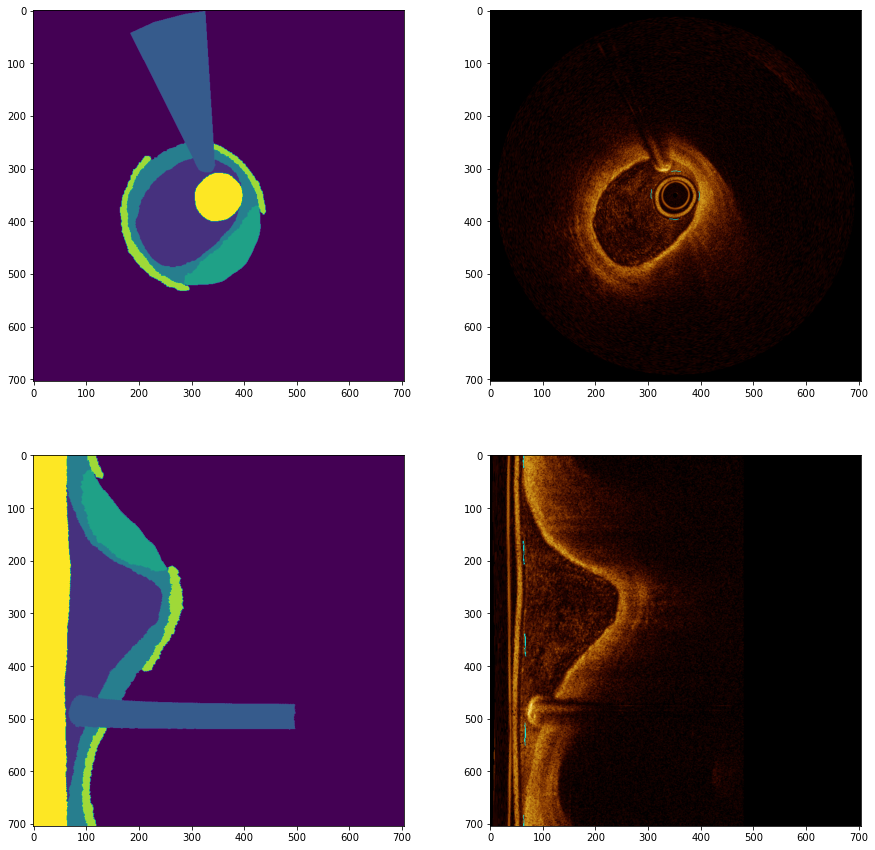

In [8]:
fig, axes = plt.subplots(2,2, figsize=(15,15))

axes = axes.flatten()

axes[0].imshow(frame_sample)
axes[1].imshow(frame_image)
axes[2].imshow(polar_seg)
axes[3].imshow(polar_img[frame,:,:,:].astype(np.int32))


## Guidewire shadow removal

In [69]:
rows, cols = polar_seg.shape

lumen = np.zeros((polar_seg.shape))

for i in range(rows):
    for j in range(cols):

        #if polar_seg[i, j] == 1 or polar_seg[i, j] == 7:
            #lumen[i, j] = 1

        if polar_seg[i, j] == 3:
            lumen[i, j] = 1
        
        else:
            lumen[i, j] = 0


In [70]:
kernel = skimage.morphology.disk(5)

closing = cv2.morphologyEx(lumen, cv2.MORPH_CLOSE, kernel)
#opening = cv2.morphologyEx(closing, cv2.MORPH_OPEN, kernel)

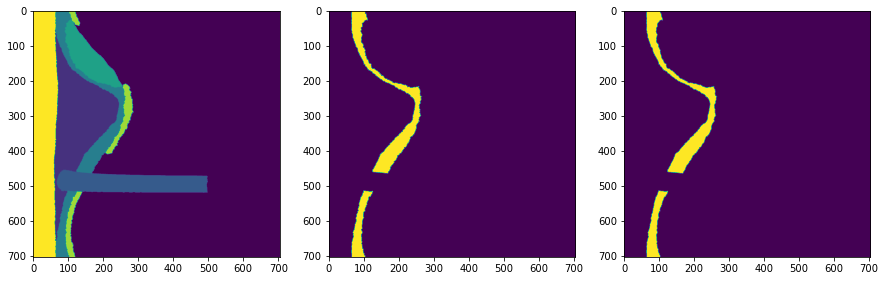

In [71]:
fig, axes = plt.subplots(1,3, figsize=(15,15))

axes[0].imshow(polar_seg)
axes[1].imshow(lumen)
axes[2].imshow(closing)

In [225]:
contours = skimage.measure.find_contours(closing)

extreme_points = []

for contour in contours:

    x, y = contour[:, 0], contour[:, 1]
    leftmost = tuple(contour[np.argmin(x)])
    rightmost = tuple(contour[np.argmax(x)])
    topmost = tuple(contour[np.argmin(y)])
    bottommost = tuple(contour[np.argmax(y)])

    extreme_points.append([leftmost, rightmost, topmost, bottommost])

[(0.0, 102.5), (465.5, 166.0), (57.0, 63.5), (246.0, 264.5)]
[(514.5, 98.0), (703.0, 64.5), (692.0, 63.5), (516.0, 124.5)]


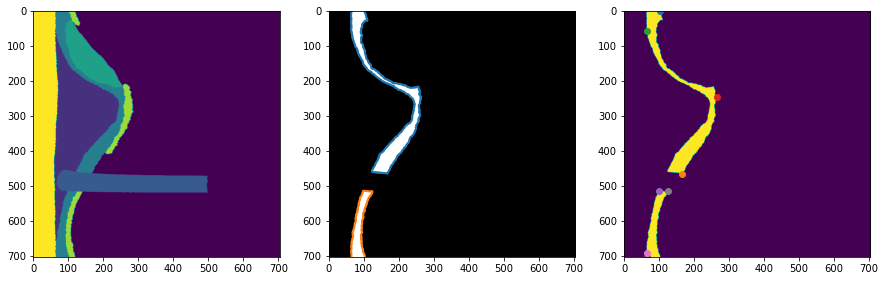

In [230]:
fig, ax = plt.subplots(1,3, figsize=(15,15))
ax[0].imshow(polar_seg)
ax[1].imshow(closing, cmap=plt.cm.gray)

for contour in contours:
    ax[1].plot(contour[:, 1], contour[:, 0], linewidth=2)

ax[2].imshow(closing)

for cluster in extreme_points:
    print(cluster)
    for point in cluster:
        ax[2].scatter(point[1], point[0])

In [ ]:
# Sort the contour points in a clockwise or counterclockwise order
    sorted_contour_points = np.array(contour_points)
    sorted_contour_points = sorted_contour_points[np.argsort(np.arctan2(sorted_contour_points[:,1], sorted_contour_points[:,0]))]

    # Calculate the distance between each pair of adjacent points
    distances = np.sqrt(np.sum(np.diff(sorted_contour_points, axis=0)**2, axis=1))
    total_length = np.sum(distances)

    # Calculate the number of interpolated points needed between each pair of adjacent points
    num_interpolated_points = np.round(distances / spacing).astype(int)

    # Loop over each pair of adjacent points and calculate the interpolated points
    interpolated_points = []
    for i in range(len(sorted_contour_points) - 1):
        start_point = sorted_contour_points[i]
        end_point = sorted_contour_points[i+1]
        num_points = num_interpolated_points[i]

        for j in range(num_points):
            t = (j+1) / (num_points+1)
            interpolated_point = start_point + t * (end_point - start_point)
            interpolated_points.append(interpolated_point)

    # Combine the original contour points and interpolated points
    interpolated_contour = np.vstack((sorted_contour_points, interpolated_points))


In [70]:
rows, cols = frame_sample.shape

final_seg = np.zeros((frame_sample.shape))

for i in range(rows):
    for j in range(cols):

        if closing[i, j] == 1:
            final_seg[i, j] = 1

        else:
            final_seg[i, j] = frame_sample[i, j]

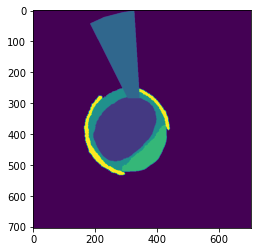

In [71]:
plt.imshow(final_seg)

## Cost function

In [18]:
## Cost function
##1 mm = 100 px
## Need to tune these parameters

def create_function(img, dl = 7, dmax = 38, lamda = 7, L = 4):

    n, m, _ = img.shape
    cost = np.zeros((n, m))

    j_alphas_1_mean = np.zeros((n, m-1))
    j_alphas_2_mean = np.zeros((n, m-1))

    #First part
    for j in range(m-1):

        j_alphas_1 = img[:, max(0, j-dl):j, 0]
        j_alphas_1_mean[:, j] = np.where(j_alphas_1 != 0, j_alphas_1, 0).mean(axis=1)
        
        j_alphas_2 = img[:, j:j+dmax, 0]
        j_alphas_2_mean[:, j] = np.where(j_alphas_2 != 0, j_alphas_2, 0).mean(axis=1)
    
    #Second part
    for i in range(n):

        #Calculate mu
        segment = np.zeros((L,))
        

        for j in range(m-1):
    
            segment[L//2] = img[i, j, 0]
            segment[:L//2] = img[i, j+1:j+L//2+1, 0]
            segment[L//2:] = img[i, j-L//2+2:j+1, 0]
            mu = np.mean(segment)

            cost[i, j] =  j_alphas_1_mean[i, j] + j_alphas_2_mean[i, j] - lamda * mu

    return cost
            

In [19]:
function_cartesian = create_function(frame_image)
function_polar = create_function(polar_img)

C:\Users\gonza\AppData\Local\Temp\ipykernel_13784\593552904.py:17: RuntimeWarning: Mean of empty slice.
  j_alphas_1_mean[:, j] = np.where(j_alphas_1 != 0, j_alphas_1, 0).mean(axis=1)
f:\NO_BACKUP\anaconda3\envs\ai_master\lib\site-packages\numpy\core\_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


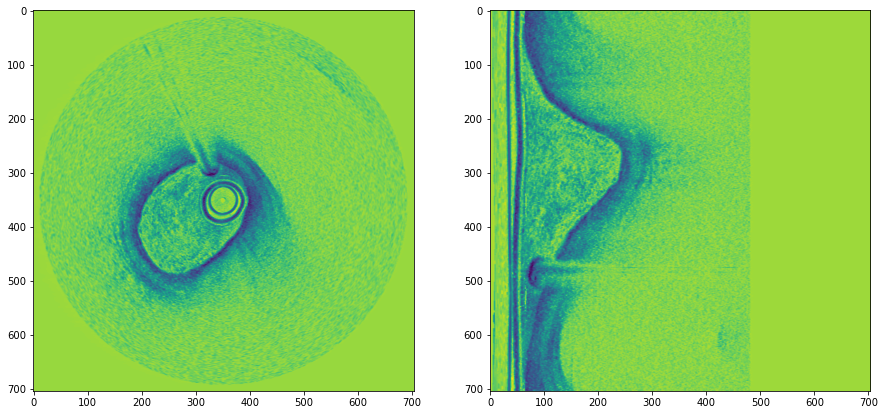

In [20]:
fig, axes = plt.subplots(1,2, figsize=(15,15))

axes = axes.flatten()

axes[0].imshow(function_cartesian)
axes[1].imshow(function_polar)

In [91]:
n, m = function_cartesian.shape

thresh_img = np.zeros((function_cartesian.shape))

for i in range(n):
    for j in range(m):
        if function_cartesian[i, j] < -400:
            thresh_img[i, j] = function_cartesian[i, j]

        else:
            thresh_img[i, j] = 0

In [92]:
lipid_mask = np.zeros((function_cartesian.shape))
wall_mask = np.zeros((function_cartesian.shape))

for i in range(n):
    for j in range(m):
        if seg_sample_pixel_array[frame, i, j] == 4:
            lipid_mask[i,j] = 1

        else:
            lipid_mask[i,j] = 0

for i in range(n):
    for j in range(m):
        if seg_sample_pixel_array[frame, i, j] == 3:
            wall_mask[i,j] = 2

        else:
            wall_mask[i,j] = 0


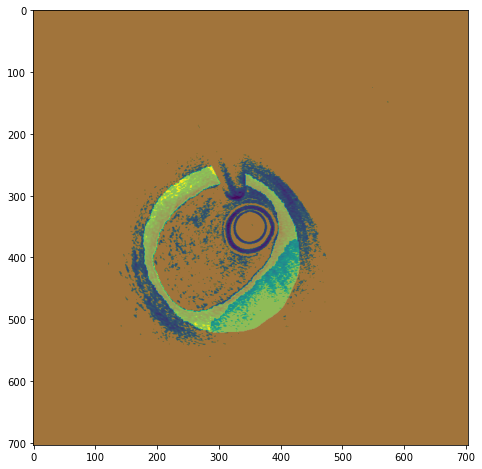

In [93]:
fig, _ = plt.subplots(1, figsize=(8,8))

segmentation_mask = wall_mask + lipid_mask

plt.imshow(thresh_img)
#plt.imshow(wall_mask, alpha=0.5)
#plt.imshow(lipid_mask, alpha=0.5)
plt.imshow(segmentation_mask, alpha=0.5)

## Dynamic programming

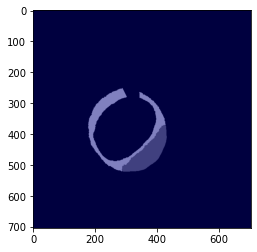

In [236]:
direction_penalty = 0.1


dp_matrix = np.zeros_like(segmentation_mask, dtype=float)
dp_matrix[0, :] = function_cartesian[0,:]
#dp_matrix[1:, :] = -1000

for i in range(1, segmentation_mask.shape[0]):

    for j in range(segmentation_mask.shape[1]):

        if segmentation_mask[i, j] != 0:

            left_cost = dp_matrix[i - 1, j] + function_cartesian[i, j] - direction_penalty if j != np.argmax(dp_matrix[i - 1, :]) else dp_matrix[i - 1, j] + thresh_img[i, j]
            up_cost = dp_matrix[i, j - 1] + function_cartesian[i, j] - direction_penalty if i != segmentation_mask.shape[0] - 1 else np.inf
            right_cost = dp_matrix[i + 1, j] + function_cartesian[i, j] - direction_penalty if i != segmentation_mask.shape[0] - 1 else np.inf
            down_cost = dp_matrix[i, j + 1] + function_cartesian[i, j] - direction_penalty if j != segmentation_mask.shape[0] - 1 else dp_matrix[i - 1, j] + thresh_img[i, j]
            
            dp_matrix[i, j] = max(left_cost, up_cost, down_cost, right_cost)

        else:
            dp_matrix[i, j] = 0
    

path = np.zeros_like(segmentation_mask, dtype=float)
path[-1, np.argmax(dp_matrix[-1, :])] = 1

for i in range(segmentation_mask.shape[0] - 2, -1, -1):
    j = np.argmin([
        dp_matrix[i, max(j - 1, 0)],
        dp_matrix[i, j],
        dp_matrix[i, min(j + 1, segmentation_mask.shape[1] - 1)]
    ])
    #j = np.where(dp_matrix[i] == np.max(dp_matrix[i]))[0][0] # Find the index of the maximum value in the current row
    path[i, j] = 1
    path = np.flip(path, axis=0)


plt.imshow(segmentation_mask, cmap='gray')
plt.imshow(path, cmap='jet', alpha=0.5)
plt.show()

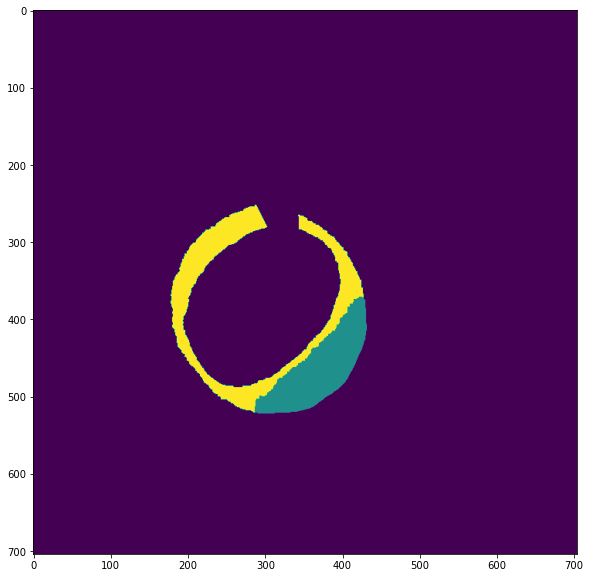

In [238]:
fig, _ = plt.subplots(1, figsize=(10,10))


plt.imshow(segmentation_mask)

In [8]:
num_frames, num_alines, num_pixels, num_channels = img_sample_pixel_array.shape

avg_intensities = np.zeros((num_alines, num_frames, num_channels), dtype=np.float64)

for frame in range(num_frames):
    for channel in range(num_channels):
     
        alines = [img_sample_pixel_array[frame, :, i, channel] for i in range(num_pixels)]
       
        avg_intensities[:, frame, channel] = [np.mean(aline) for aline in alines]

max_val = np.max(avg_intensities)
min_val = np.min(avg_intensities)
avg_intensities = (avg_intensities - min_val) / (max_val - min_val)

single_lines = [np.array(avg_intensities[frame]) for frame in range(num_frames)]

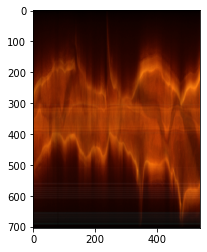

In [14]:
plt.imshow(avg_intensities)